In [248]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Create Dataset

In [249]:
MAX_LEN = 40

def generate_sentence(min_len=0, max_len=20, pos=True):
    if pos:
        n = np.random.randint(np.ceil(min_len / 3), np.ceil((max_len) / 3))
        sentence = n*"a" + n*"b" + n*"c"
        return sentence, len(sentence)
    else:
        n_0 = np.random.randint(0, max_len)
        n_1 = np.random.randint(0, max_len - n_0 + 1)
        n_2 = np.random.randint(min_len - n_0 - n_1, max_len - n_0 - n_1 + 1)
        sentence = n_0 * "a" + n_1 * "b" + n_2 * "c"
        return sentence, len(sentence)

def create_data(size=10000, balance=0.1, min_len=0, max_len=20, train=True):
    data = []
    sentence_lengths = []

    for i in range(int(size*balance)):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        while sentence == "aabbcc" and train:
            sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        if not train:
            sentence, sentence_length = "aabbcc"
        data.append((sentence, 1))
        sentence_lengths.append(sentence_length)
    for i in range(int((size - (size*balance)))):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=False)
        data.append((sentence, 0))
        sentence_lengths.append(sentence_length)
    
    random.shuffle(data)
    average_length = sum(sentence_lengths) / len(sentence_lengths)
    return data, average_length

train_data, avg_sent_length_train = create_data(size=1000, balance=0.1, min_len=0, max_len=20, train=True)
val_data, avg_sent_length_val = create_data(size=1000, balance=0.1, min_len=0, max_len=20, train=False)
test_data, avg_sent_length_test = create_data(size=1000, balance=0.1, min_len=21, max_len=MAX_LEN, train=True)

print(f"Train Data Sample:\n{train_data}")
print(f"Average Sentence Length:\n{avg_sent_length_train}")
print(f"Val Data Sample:\n{val_data}")
print(f"Average Sentence Length:\n{avg_sent_length_val}")
print(f"Test Data Sample:\n{test_data}")
print(f"Average Sentence Length:\n{avg_sent_length_test}")


Train Data Sample:
[('aaaabbbbbbbbbb', 0), ('aaaaaaaaaaabbbbbbbb', 0), ('bbbbbbbccccccccccc', 0), ('aaaaaaaaaaaaaaaabb', 0), ('aaaaaaaaaaaaaaaabb', 0), ('aaaaaaaaaabbbb', 0), ('aaaaaaaaaaaaaaabbbbb', 0), ('aaaabbbbbbbbbbbbbbcc', 0), ('aabbbbccccc', 0), ('aaaabbbbbbbbbbbbbbb', 0), ('bbbbbbbbbbbbb', 0), ('aaaaaaaaaaaaaaaaaa', 0), ('aaaaaaaaaaaaa', 0), ('aaaa', 0), ('aaaaaaaaaaaaaaaabbbb', 0), ('aaaaaaaaaaaaaaaabbbb', 0), ('', 1), ('aaaaaabbbcc', 0), ('aaabbbbbbbbbbbbbbb', 0), ('aabbccccccccccc', 0), ('bbbbbbbbbbbbbbbb', 0), ('aaaaaaaaaaaaaaaaaaab', 0), ('aaaaaaaaaabbbbbb', 0), ('aaaaaaaaaaaaaaacc', 0), ('aaaaaaaaaaaaabbbbbbb', 0), ('aaaaaaaaaaaaaaaaaaa', 0), ('aaaaaaaabbbbbbbbbbbc', 0), ('aaaaaaaaaaaabbbbbbbb', 0), ('aaaaaaaaaaaaabbb', 0), ('aaaaaaaaaaaaaab', 0), ('aaabbbccc', 1), ('aaaaabbbbbbbbbbbbbbb', 0), ('aaaaaaaaaaaaaaaaab', 0), ('aaaaaaaaaaaaaaaaa', 0), ('aaaaaaaaaaaaaaaaaabb', 0), ('aabbbb', 0), ('aaaaaaaaaaaaaaaaaabb', 0), ('aaaaaaaaaabbbbbbbb', 0), ('aaaabbbbbbbbbcccc', 0), ('

In [250]:
# Dependencies
import torch
import torch.nn as nn
import torch.optim as optim

In [251]:
# Encoding data
char_to_index = {'a':[1,0,0], 'b':[0,1,0], 'c':[0,0,1]}
#index_to_char = {v: k for k, v in char_to_index.items()}

def creat_tensors(data, max_l):
    X = []
    y = []
    ml = 0

    for sent, label in data:
        X.append([char_to_index[char] for char in sent])
        y.append(label)

    # Padding to be able to convert to tensor
    X = [sent + [[0,0,0]] * (max_l - len(sent)) for sent in X]

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)

    return X, y

X_train, y_train = creat_tensors(train_data, max_l=MAX_LEN)
X_test, y_test = creat_tensors(test_data, max_l=MAX_LEN)
X_val, y_val = creat_tensors(val_data, max_l=MAX_LEN)

In [252]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
train_set = TensorDataset(X_train, y_train)
val_set = TensorDataset(X_val, y_val)
testset = TensorDataset(X_test, y_test)

train_set, val_same_set = torch.utils.data.random_split(train_set, [900, 100])


train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
val_same_loader = DataLoader(val_same_set, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(testset, BATCH_SIZE, shuffle=True)

## Train and define model

In [253]:
# Set device
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps:0'
else:
    device = 'cpu'
print('GPU State:', device)

GPU State: cpu


In [254]:
class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, hidden_depth) -> None:
        super().__init__()

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, hidden_depth, batch_first=True)
        self.classification= nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        
        logits = self.classification(output[:,-1,:])
        #print(logits.size())
        return torch.squeeze(logits)

In [322]:
input_size = X_train.shape[2]
hidden_size = 3
hidden_depth = 1
num_epochs = 300
lr=0.01

model = LSTM(input_size, hidden_size, hidden_depth)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
        # Forward pass
        #print(inputs.shape)
        outputs = model(inputs)
        #print(outputs.shape)
        #print(outputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# for param in model.parameters():
#     print(param5

Epoch [10/300], Loss: 0.3525
Epoch [20/300], Loss: 0.3523
Epoch [30/300], Loss: 0.3530
Epoch [40/300], Loss: 0.3182
Epoch [50/300], Loss: 0.3534
Epoch [60/300], Loss: 0.3185
Epoch [70/300], Loss: 0.3184
Epoch [80/300], Loss: 0.3183
Epoch [90/300], Loss: 0.3182
Epoch [100/300], Loss: 0.3185
Epoch [110/300], Loss: 0.3530
Epoch [120/300], Loss: 0.3191
Epoch [130/300], Loss: 0.2177
Epoch [140/300], Loss: 0.1572
Epoch [150/300], Loss: 0.1619
Epoch [160/300], Loss: 0.1345
Epoch [170/300], Loss: 0.0985
Epoch [180/300], Loss: 0.0998
Epoch [190/300], Loss: 0.0919
Epoch [200/300], Loss: 0.0810
Epoch [210/300], Loss: 0.0702
Epoch [220/300], Loss: 0.0908
Epoch [230/300], Loss: 0.1560
Epoch [240/300], Loss: 0.1379
Epoch [250/300], Loss: 0.0885
Epoch [260/300], Loss: 0.0690
Epoch [270/300], Loss: 0.0688
Epoch [280/300], Loss: 0.0686
Epoch [290/300], Loss: 0.0686
Epoch [300/300], Loss: 0.0718


## Testing

In [323]:
from torcheval.metrics import BinaryF1Score

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")

            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


test_loop(val_loader, model, loss_fn)

Test Error: 
 Accuracy: 97.5%, F1-score: 0.888888955116272, Avg loss: 0.063324 



In [324]:
test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 95.1%, F1-score: 0.7199999094009399, Avg loss: 0.109580 



In [325]:
test_loop(val_same_loader, model, loss_fn)

Test Error: 
 Accuracy: 99.0%, F1-score: 0.9333333373069763, Avg loss: 0.039658 



Test Error: 
 Accuracy: 90.7%, F1-score: 0.3007518947124481, Avg loss: 0.473236 



([<matplotlib.axis.XTick at 0x7f060b66b440>,
 [Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33'),
  Text(34, 0, '34'),
  Text(35, 0, '35'),
  Text(36, 0, '36'),
  Text(37, 0, '37'),
  Text(38, 0, '38'),
  Text(39, 0, '39'),
  Text(40, 0, '40')])

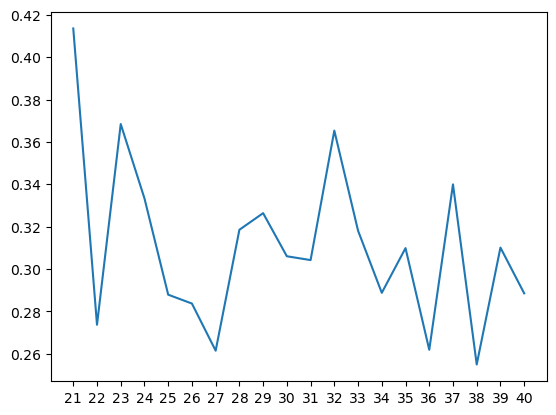

In [293]:
from torcheval.metrics import BinaryF1Score

def get_plot(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    metric_per_len = [BinaryF1Score() for i in range(21, MAX_LEN + 1)]
    #print(len(metric_per_len))
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")
            for i in range(X.shape[0]):
                sent_len = int(X[i].flatten().sum().item())
                metric_per_len[sent_len - 21].update(pred, y)

            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
    return metric_per_len

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = get_plot(test_loader, model, loss_fn)

f1_scores = [metric.compute() for metric in metrics]
f1_scores

plt.plot(range(21, MAX_LEN + 1), f1_scores)
plt.xticks(range(21, MAX_LEN + 1))

## Parameter sweep

In [260]:
sweep_config = {
    'method': 'random',
}

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'hidden_size': {
        'values': [3, 5, 10, 20]
    },
    'hidden_depth': {
        'values': [1, 2, 3]
    },
    'lr': {
        'values': [1e-2, 1e-3, 1e-4]
    },
    'num_epochs': {
        'values': [100, 200, 300]
    },
}

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'hidden_depth': {'values': [1, 2, 3]},
                'hidden_size': {'values': [3, 5, 10, 20]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_epochs': {'values': [100, 200, 300]}}}


In [261]:
import wandb
sweep_id = wandb.sweep(sweep_config, project='lstm-sweep')

Create sweep with ID: qj063yx9
Sweep URL: https://wandb.ai/jarlku/lstm-sweep/sweeps/qj063yx9


In [262]:

def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_set, BATCH_SIZE, shuffle=True)
        
        model = LSTM(input_size, config.hidden_size, config.hidden_depth)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.BCELoss()
        

        for epoch in range(config.num_epochs):
            model.train()
            epoch_loss = 0

            for batch_idx, (inputs, targets) in enumerate(train_loader):
                #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
                # Forward pass
                outputs = model(inputs)
                #print(outputs)
                loss = criterion(outputs, targets)
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            wandb.log({'loss': epoch_loss / len(train_loader)})
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')
        
        metric = BinaryF1Score()
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            wandb.log({'val_loss': loss})
            metric.update(outputs, targets)
            wandb.log({'val_f1': metric.compute()})
            
            

wandb.agent(sweep_id, train, count=5)

In [263]:
wandb.agent(sweep_id, train_wandb, count=10)

wandb: Agent Starting Run: m8aqo77f with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 10
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.3539
Epoch [20/200], Loss: 0.3241
Epoch [30/200], Loss: 0.3872
Epoch [40/200], Loss: 0.3185
Epoch [50/200], Loss: 0.3184
Epoch [60/200], Loss: 0.3186
Epoch [70/200], Loss: 0.3855
Epoch [80/200], Loss: 0.3521
Epoch [90/200], Loss: 0.3219
Epoch [100/200], Loss: 0.3864
Epoch [110/200], Loss: 0.3188
Epoch [120/200], Loss: 0.3876
Epoch [130/200], Loss: 0.3215
Epoch [140/200], Loss: 0.3184
Epoch [150/200], Loss: 0.3888
Epoch [160/200], Loss: 0.3197
Epoch [170/200], Loss: 0.3200
Epoch [180/200], Loss: 0.3184
Epoch [190/200], Loss: 0.3258
Epoch [200/200], Loss: 0.3526


loss,█▃▁▁▃▁▁▁▁▃▁▁▁▁▁▁▁▁▁▃▁▁▃▃▁▁▃▁▁▁▃▁▁▁▁▁▁▁▁▃
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▁▄▁█▃▃▃▁▆▁▃▂▂▃▃
loss,0.35262
val_f1,0.0
val_loss,0.32535


wandb: Agent Starting Run: 4achu99l with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 10
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.3201
Epoch [20/200], Loss: 0.3182
Epoch [30/200], Loss: 0.3178
Epoch [40/200], Loss: 0.3527
Epoch [50/200], Loss: 0.3514
Epoch [60/200], Loss: 0.3216
Epoch [70/200], Loss: 0.3184
Epoch [80/200], Loss: 0.3533
Epoch [90/200], Loss: 0.3186
Epoch [100/200], Loss: 0.3185
Epoch [110/200], Loss: 0.3518
Epoch [120/200], Loss: 0.3539
Epoch [130/200], Loss: 0.3542
Epoch [140/200], Loss: 0.3186
Epoch [150/200], Loss: 0.3186
Epoch [160/200], Loss: 0.3184
Epoch [170/200], Loss: 0.3184
Epoch [180/200], Loss: 0.3186
Epoch [190/200], Loss: 0.3188
Epoch [200/200], Loss: 0.3185


loss,▁▁▁▅▂▁▁▅▅▅▄▁▁▁▂▁▄▁▁▁▅▁▁▁▁▁█▁▁▁▅▁▄▄▅▁▅▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▂▂▄▂▂▄▂▁▂▂▃█▂▅
loss,0.3185
val_f1,0.0
val_loss,0.38266


wandb: Agent Starting Run: y9niv9ic with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 5
wandb: 	lr: 0.001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.5067
Epoch [20/100], Loss: 0.3350
Epoch [30/100], Loss: 0.3200
Epoch [40/100], Loss: 0.3518
Epoch [50/100], Loss: 0.3187
Epoch [60/100], Loss: 0.3185
Epoch [70/100], Loss: 0.3869
Epoch [80/100], Loss: 0.3867
Epoch [90/100], Loss: 0.3858
Epoch [100/100], Loss: 0.3521


loss,█▇▆▅▃▃▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▂▂▁▁▁▁▂▁▁▁▁▂
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▂▂▄█▁▇█▄▂▂▅▃▄▅▁
loss,0.3521
val_f1,0.0
val_loss,0.21747


wandb: Agent Starting Run: sfz8idw8 with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 20
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.3178
Epoch [20/200], Loss: 0.3197
Epoch [30/200], Loss: 0.3589
Epoch [40/200], Loss: 0.3510
Epoch [50/200], Loss: 0.3185
Epoch [60/200], Loss: 0.3192
Epoch [70/200], Loss: 0.3222
Epoch [80/200], Loss: 0.3224
Epoch [90/200], Loss: 0.3529
Epoch [100/200], Loss: 0.3531
Epoch [110/200], Loss: 0.3540
Epoch [120/200], Loss: 0.3529
Epoch [130/200], Loss: 0.3200
Epoch [140/200], Loss: 0.3531
Epoch [150/200], Loss: 0.3185
Epoch [160/200], Loss: 0.3176
Epoch [170/200], Loss: 0.3204
Epoch [180/200], Loss: 0.3228
Epoch [190/200], Loss: 0.3202
Epoch [200/200], Loss: 0.3197


loss,▅▁▁▁█▅▁▅▁▅▄▁▂▁▂█▁▁▁▅▁▁▂▅█▅▄▁▁▁▅▅▁▁▁▂▁▂▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▃▇▃▃▃▃▃█▅▇▁▅▅▃▄
loss,0.31968
val_f1,0.0
val_loss,0.3253


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0jsbbbco with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 3
wandb: 	lr: 0.01
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.3184
Epoch [20/100], Loss: 0.3183
Epoch [30/100], Loss: 0.3197
Epoch [40/100], Loss: 0.3529
Epoch [50/100], Loss: 0.3521
Epoch [60/100], Loss: 0.3208
Epoch [70/100], Loss: 0.3184
Epoch [80/100], Loss: 0.3190
Epoch [90/100], Loss: 0.3539
Epoch [100/100], Loss: 0.3199


loss,█▂▁▁▂▁▁▁▁▁▂▁▂▂▂▁▂▁▁▁▁▁▁▂▁▂▁▁▂▁▁▂▁▁▂▁▁▂▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▂▅▂▇▅▄█▅▁▄▆▄▅▂▂
loss,0.31992
val_f1,0.0
val_loss,0.22325


wandb: Agent Starting Run: vy70d7gj with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 3
wandb: 	lr: 0.01
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.3183
Epoch [20/300], Loss: 0.3185
Epoch [30/300], Loss: 0.3526
Epoch [40/300], Loss: 0.3529
Epoch [50/300], Loss: 0.3184
Epoch [60/300], Loss: 0.3183
Epoch [70/300], Loss: 0.3194
Epoch [80/300], Loss: 0.3194
Epoch [90/300], Loss: 0.3188
Epoch [100/300], Loss: 0.3183
Epoch [110/300], Loss: 0.2137
Epoch [120/300], Loss: 0.1625
Epoch [130/300], Loss: 0.1562
Epoch [140/300], Loss: 0.1675
Epoch [150/300], Loss: 0.1404
Epoch [160/300], Loss: 0.1369
Epoch [170/300], Loss: 0.1241
Epoch [180/300], Loss: 0.1247
Epoch [190/300], Loss: 0.1454
Epoch [200/300], Loss: 0.1236
Epoch [210/300], Loss: 0.1340
Epoch [220/300], Loss: 0.1493
Epoch [230/300], Loss: 0.1256
Epoch [240/300], Loss: 0.1308
Epoch [250/300], Loss: 0.1558
Epoch [260/300], Loss: 0.1355
Epoch [270/300], Loss: 0.1256
Epoch [280/300], Loss: 0.1149
Epoch [290/300], Loss: 0.1143
Epoch [300/300], Loss: 0.1148


loss,█▇██▇███▇▇▇▇█▇▄▃▂▂▃▂▂▂▁▂▁▂▁▁▁▂▂▃▁▂▂▁▁▁▁▁
val_f1,▃▄▁▄▂▃▅▅▅▅▆▆▇▇██
val_loss,▇▅▃▃▅▃▅▃▇▄▄▆█▁▅▃
loss,0.11476
val_f1,0.71685
val_loss,0.09049


wandb: Agent Starting Run: u1liqlku with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 5
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.4289
Epoch [20/200], Loss: 0.3364
Epoch [30/200], Loss: 0.3227
Epoch [40/200], Loss: 0.3192
Epoch [50/200], Loss: 0.3185
Epoch [60/200], Loss: 0.3521
Epoch [70/200], Loss: 0.3524
Epoch [80/200], Loss: 0.3183
Epoch [90/200], Loss: 0.3526
Epoch [100/200], Loss: 0.3189
Epoch [110/200], Loss: 0.3183
Epoch [120/200], Loss: 0.3183
Epoch [130/200], Loss: 0.3183
Epoch [140/200], Loss: 0.3183
Epoch [150/200], Loss: 0.3185
Epoch [160/200], Loss: 0.3183
Epoch [170/200], Loss: 0.3184
Epoch [180/200], Loss: 0.3184
Epoch [190/200], Loss: 0.3520
Epoch [200/200], Loss: 0.3187


loss,█▆▃▂▁▁▁▁▁▁▂▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▂▂▁▁▂▁▂▁▁▁▂▂▂▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▄▂▃▄▄▂█▂▆▃▃▅▃▅▆
loss,0.31866
val_f1,0.0
val_loss,0.43197


wandb: Agent Starting Run: ou01lqbv with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 3
wandb: 	lr: 0.0001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.6325
Epoch [20/100], Loss: 0.6078
Epoch [30/100], Loss: 0.5898
Epoch [40/100], Loss: 0.5649
Epoch [50/100], Loss: 0.5598
Epoch [60/100], Loss: 0.5453
Epoch [70/100], Loss: 0.5160
Epoch [80/100], Loss: 0.5028
Epoch [90/100], Loss: 0.4910
Epoch [100/100], Loss: 0.4805


loss,██▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▆▃▅▂▂▁▂▃▂▂▄▄▁
loss,0.48046
val_f1,0.0
val_loss,0.4489


wandb: Agent Starting Run: fq9n2jf9 with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 10
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.3191
Epoch [20/200], Loss: 0.3188
Epoch [30/200], Loss: 0.3184
Epoch [40/200], Loss: 0.3183
Epoch [50/200], Loss: 0.3183
Epoch [60/200], Loss: 0.3871
Epoch [70/200], Loss: 0.3185
Epoch [80/200], Loss: 0.3524
Epoch [90/200], Loss: 0.3183
Epoch [100/200], Loss: 0.3507
Epoch [110/200], Loss: 0.1878
Epoch [120/200], Loss: 0.1715
Epoch [130/200], Loss: 0.1352
Epoch [140/200], Loss: 0.1056
Epoch [150/200], Loss: 0.0660
Epoch [160/200], Loss: 0.0483
Epoch [170/200], Loss: 0.0672
Epoch [180/200], Loss: 0.0337
Epoch [190/200], Loss: 0.0185
Epoch [200/200], Loss: 0.0134


loss,█▅▅▄▅▄▄▅▅▅▄▄▄▄▄▄▅▄▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▁▃▃▄▃▅▅▅▅▅▁▇▆▆█
loss,0.01341
val_f1,0.0
val_loss,0.60376


wandb: Agent Starting Run: w7cetz3d with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 20
wandb: 	lr: 0.001
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.3192
Epoch [20/200], Loss: 0.3828
Epoch [30/200], Loss: 0.3854
Epoch [40/200], Loss: 0.1812
Epoch [50/200], Loss: 0.1558
Epoch [60/200], Loss: 0.1722
Epoch [70/200], Loss: 0.1455
Epoch [80/200], Loss: 0.1043
Epoch [90/200], Loss: 0.0712
Epoch [100/200], Loss: 0.0874
Epoch [110/200], Loss: 0.0876
Epoch [120/200], Loss: 0.0561
Epoch [130/200], Loss: 0.0476
Epoch [140/200], Loss: 0.0536
Epoch [150/200], Loss: 0.0423
Epoch [160/200], Loss: 0.0856
Epoch [170/200], Loss: 0.0569
Epoch [180/200], Loss: 0.0432
Epoch [190/200], Loss: 0.0364
Epoch [200/200], Loss: 0.0922


loss,█▅▅▅▅▅▅▄▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▃▂▁▂▁▁▁▁▁▂
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁█▁█▃▂▃▃▂▇▄▃▃▅▅
loss,0.09219
val_f1,0.0
val_loss,0.17638
